In [4]:
import desdeo

# UTOPIA problem and imports

In [5]:
import numpy as np

from desdeo.problem import (PolarsEvaluator, Problem, VariableType,
                            variable_dict_to_numpy_array, Constraint,
                            ConstraintTypeEnum, Variable, VariableTypeEnum, ScalarizationFunction
                            )
from desdeo.tools.utils import (
    get_corrected_ideal_and_nadir,
    get_corrected_reference_point,
)
from desdeo.tools.scalarization import objective_dict_has_all_symbols

from desdeo.problem.testproblems import dtlz2, nimbus_test_problem

# from desdeo.mcdm.gnimbus import infer_classifications, solve_intermediate_solutions, solve_sub_problems
from gnimbus import (explain, voting_procedure, infer_classifications, agg_cardinal, infer_ordinal_classifications,
                     solve_intermediate_solutions, solve_sub_problems, convert_to_nimbus_classification, add_group_nimbusv2_sf_diff,
                     list_of_rps_to_dict_of_rps, dict_of_rps_to_list_of_rps)

from desdeo.problem import dtlz2, nimbus_test_problem, zdt1, zdt2, forest_problem, forest_problem_discrete
from desdeo.tools import IpoptOptions, PyomoIpoptSolver, add_asf_diff

from aggregate_classifications import aggregate_classifications

from gnimbus import *

from desdeo.tools import (
    BaseSolver,
    SolverOptions,
    SolverResults,
    add_group_asf_diff,
    add_group_asf,
    add_group_guess_sf_diff,
    add_group_guess_sf,
    add_group_nimbus_sf_diff,
    add_group_nimbus_sf,
    add_group_stom_sf_diff,
    add_group_stom_sf,
    guess_best_solver,
    add_asf_diff,
    ScalarizationError,
    add_nimbus_sf_diff, add_nimbus_sf_nondiff
)
from desdeo.mcdm.nimbus import (
    generate_starting_point,
    infer_classifications,
    NimbusError
)

from desdeo.tools.scalarization import add_asf_diff
from desdeo.tools import guess_best_solver

from desdeo.mcdm.nimbus import generate_starting_point

from aggregate_classifications import aggregate_classifications
import math
import numpy as np
from pathlib import Path
import polars as pl

from desdeo.problem.schema import (
    Constant,
    Constraint,
    ConstraintTypeEnum,
    DiscreteRepresentation,
    ExtraFunction,
    Objective,
    ObjectiveTypeEnum,
    Problem,
    TensorConstant,
    TensorVariable,
    Variable,
    VariableTypeEnum,
)
from desdeo.tools.utils import available_solvers, payoff_table_method


def utopia_problem_old2(problem_name: str = "Forest problem", holding: int = 1) -> tuple[Problem, dict]:
    r"""Defines a test forest problem that has TensorConstants and TensorVariables.

    The problem has TensorConstants V, W and P as vectors taking values from a data file and
    TensorVariables X_n, where n is the number of units in the data, as vectors matching the constants in shape.
    The variables are binary and each variable vector X_i has one variable with the value 1 while others have value 0.
    The variable with the value 1 for each vector X_i represents the optimal plan for the corresponding unit i.
    The three objective functions f_1, f_2, f_3 represent the net present value, wood volume at the end of
    the planning period, and the profit from harvesting.
    All of the objective functions are to be maximized.
    The problem is defined as follows:

    \begin{align}
        \mbox{maximize~} & \sum_{j=1}^N\sum_{i \in I_j} v_{ij} x_{ij} & \\
        \mbox{maximize~} & \sum_{j=1}^N\sum_{i \in I_j} w_{ij} x_{ij} & \\
        \mbox{maximize~} & \sum_{j=1}^N\sum_{i \in I_j} p_{ij} x_{ij} & \\
        \nonumber\\
        \mbox{subject to~} &  \sum\limits_{i \in I_j} x_{ij} = 1, & \forall j = 1 \ldots N \\
        & x_{ij}\in \{0,1\}& \forall j = 1 \ldots N, ~\forall i\in I_j,
    \end{align}

    where $x_{ij}$ are decision variables representing the choice of implementing management plan $i$ in stand $j$,
    and $I_j$ is the set of available management plans for stand $j$. For each plan $i$ in stand $j$
    the net present value, wood volume at the end of the planning period, and the profit from harvesting
    are represented by $v_{ij}$, $w_{ij}$, and $p_{ij}$ respectively.

    Args:
        holding (int, optional): The number of the holding to be optimized. Defaults to 1.
        comparing (bool, optional): Determines if solutions are to be compared to those from the rahti app.
            Defaults to None.

    Returns:
        Problem: An instance of the test forest problem.
    """
    # TODO: remove this at some point
    comparing = False

    schedule_dict = {}

    discounting_factor = 3  # This can be 1, 2, 3, 4 or 5. It represents %
    discounting = [
        (1 - 0.01 * discounting_factor) ** 3,
        (1 - 0.01 * discounting_factor) ** 8,
        (1 - 0.01 * discounting_factor) ** 13,
    ]

    df = pl.read_csv("alternatives_290124.csv", dtypes={"unit": pl.Float64})
    df_key = pl.read_csv("alternatives_key_290124.csv", dtypes={"unit": pl.Float64})

    selected_df_v = df.filter(pl.col("holding") == holding).select(
        ["unit", "schedule", f"npv_{discounting_factor}_percent"]
    )
    unique_units = selected_df_v.unique(["unit"], maintain_order=True).get_column("unit")
    selected_df_v.group_by(["unit", "schedule"])
    rows_by_key = selected_df_v.rows_by_key(key=["unit", "schedule"])
    v_array = np.zeros((selected_df_v["unit"].n_unique(), selected_df_v["schedule"].n_unique()))
    for i in range(np.shape(v_array)[0]):
        for j in range(np.shape(v_array)[1]):
            if (unique_units[i], j) in rows_by_key:
                v_array[i][j] = rows_by_key[(unique_units[i], j)][0]

    # determine whether the results are to be compared to those from the rahti app (for testing purposes)
    # if compared, the stock values are calculated by substacting the value after 2025 period from
    # the value after the 2035 period (in other words, last value - first value)
    if comparing:
        selected_df_w = df.filter(pl.col("holding") == holding).select(["unit", "schedule", "stock_2025", "stock_2035"])
        selected_df_w.group_by(["unit", "schedule"])
        rows_by_key = selected_df_w.rows_by_key(key=["unit", "schedule"])
        selected_df_key_w = df_key.select(["unit", "schedule", "treatment"])
        selected_df_key_w.group_by(["unit", "schedule"])
        rows_by_key_df_key = selected_df_key_w.rows_by_key(key=["unit", "schedule"])
        w_array = np.zeros((selected_df_w["unit"].n_unique(), selected_df_w["schedule"].n_unique()))
        for i in range(np.shape(w_array)[0]):
            for j in range(np.shape(w_array)[1]):
                if len(rows_by_key_df_key[(unique_units[i], j)]) == 0:
                    continue
                if (unique_units[i], j) in rows_by_key:
                    w_array[i][j] = rows_by_key[(unique_units[i], j)][0][1] - rows_by_key[(unique_units[i], j)][0][0]
    else:
        selected_df_w = df.filter(pl.col("holding") == holding).select(["unit", "schedule", "stock_2035"])
        selected_df_w.group_by(["unit", "schedule"])
        rows_by_key = selected_df_w.rows_by_key(key=["unit", "schedule"])
        selected_df_key_w = df_key.select(["unit", "schedule", "treatment"])
        selected_df_key_w.group_by(["unit", "schedule"])
        rows_by_key_df_key = selected_df_key_w.rows_by_key(key=["unit", "schedule"])
        w_array = np.zeros((selected_df_w["unit"].n_unique(), selected_df_w["schedule"].n_unique()))
        for i in range(np.shape(w_array)[0]):
            for j in range(np.shape(w_array)[1]):
                if len(rows_by_key_df_key[(unique_units[i], j)]) == 0:
                    continue
                if (unique_units[i], j) in rows_by_key:
                    w_array[i][j] = rows_by_key[(unique_units[i], j)][0]

    """
    selected_df_p = df.filter(pl.col("holding") == holding).select(
        ["unit", "schedule", "harvest_value_period_2025", "harvest_value_period_2030", "harvest_value_period_2035"]
    )
    selected_df_p.group_by(["unit", "schedule"])
    rows_by_key = selected_df_p.rows_by_key(key=["unit", "schedule"])
    p_array = np.zeros((selected_df_p["unit"].n_unique(), selected_df_p["schedule"].n_unique()))
    discounting = [0.95**5, 0.95**10, 0.95**15]
    for i in range(np.shape(p_array)[0]):
        for j in range(np.shape(p_array)[1]):
            if (unique_units[i], j) in rows_by_key:
                p_array[i][j] = (
                    sum(x * y for x, y in zip(rows_by_key[(unique_units[i], j)][0], discounting, strict=True)) + 1e-6
                )  # the 1E-6 is to deal with an annoying corner case, don't worry about it
                v_array[i][j] += p_array[i][j]
    """

    selected_df_p1 = df.filter(pl.col("holding") == holding).select(["unit", "schedule", "harvest_value_period_2025"])
    selected_df_p1.group_by(["unit", "schedule"])
    rows_by_key = selected_df_p1.rows_by_key(key=["unit", "schedule"])
    p1_array = np.zeros((selected_df_p1["unit"].n_unique(), selected_df_p1["schedule"].n_unique()))
    for i in range(np.shape(p1_array)[0]):
        for j in range(np.shape(p1_array)[1]):
            if (unique_units[i], j) in rows_by_key:
                p1_array[i][j] = rows_by_key[(unique_units[i], j)][0] + 1e-6

    selected_df_p2 = df.filter(pl.col("holding") == holding).select(["unit", "schedule", "harvest_value_period_2030"])
    selected_df_p2.group_by(["unit", "schedule"])
    rows_by_key = selected_df_p2.rows_by_key(key=["unit", "schedule"])
    p2_array = np.zeros((selected_df_p2["unit"].n_unique(), selected_df_p2["schedule"].n_unique()))
    for i in range(np.shape(p2_array)[0]):
        for j in range(np.shape(p2_array)[1]):
            if (unique_units[i], j) in rows_by_key:
                p2_array[i][j] = rows_by_key[(unique_units[i], j)][0] + 1e-6

    selected_df_p3 = df.filter(pl.col("holding") == holding).select(["unit", "schedule", "harvest_value_period_2035"])
    selected_df_p3.group_by(["unit", "schedule"])
    rows_by_key = selected_df_p3.rows_by_key(key=["unit", "schedule"])
    p3_array = np.zeros((selected_df_p3["unit"].n_unique(), selected_df_p3["schedule"].n_unique()))
    for i in range(np.shape(p3_array)[0]):
        for j in range(np.shape(p3_array)[1]):
            if (unique_units[i], j) in rows_by_key:
                p3_array[i][j] = rows_by_key[(unique_units[i], j)][0] + 1e-6

    constants = []
    variables = []
    constraints = []
    f_1_func = []
    f_2_func = []
    p1_func = []
    p2_func = []
    p3_func = []
    # define the constants V, W and P, decision variable X, constraints, and objective function expressions in one loop
    for i in range(np.shape(v_array)[0]):
        # Constants V, W and P
        v = TensorConstant(
            name=f"V_{i+1}",
            symbol=f"V_{i+1}",
            shape=[np.shape(v_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            values=v_array[i].tolist(),
        )
        constants.append(v)
        w = TensorConstant(
            name=f"W_{i+1}",
            symbol=f"W_{i+1}",
            shape=[np.shape(w_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            values=w_array[i].tolist(),
        )
        constants.append(w)
        p1 = TensorConstant(
            name=f"P1_{i+1}",
            symbol=f"P1_{i+1}",
            shape=[np.shape(p1_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            values=p1_array[i].tolist(),
        )
        constants.append(p1)

        p2 = TensorConstant(
            name=f"P2_{i+1}",
            symbol=f"P2_{i+1}",
            shape=[np.shape(p2_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            values=p2_array[i].tolist(),
        )
        constants.append(p2)

        p3 = TensorConstant(
            name=f"P3_{i+1}",
            symbol=f"P3_{i+1}",
            shape=[np.shape(p3_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            values=p3_array[i].tolist(),
        )
        constants.append(p3)

        # Decision variable X
        x = TensorVariable(
            name=f"X_{i+1}",
            symbol=f"X_{i+1}",
            variable_type=VariableTypeEnum.binary,
            shape=[np.shape(v_array)[1]],  # NOTE: vectors have to be of form [2] instead of [2,1] or [1,2]
            lowerbounds=np.shape(v_array)[1] * [0],
            upperbounds=np.shape(v_array)[1] * [1],
            initial_values=np.shape(v_array)[1] * [0],
        )
        variables.append(x)

        # Fill out the dict with information about treatments associated with X_{i+1}
        treatment_list = (
            df_key.filter((pl.col("holding") == holding) & (pl.col("unit") == unique_units[i]))
            .get_column("treatment")
            .to_list()
        )
        schedule_dict[f"X_{i+1}"] = dict(zip(range(len(treatment_list)), treatment_list, strict=True))
        schedule_dict[f"X_{i+1}"]["unit"] = unique_units[i]

        # Constraints
        con = Constraint(
            name=f"x_con_{i+1}",
            symbol=f"x_con_{i+1}",
            cons_type=ConstraintTypeEnum.EQ,
            func=f"Sum(X_{i+1}) - 1",
            is_twice_differentiable=True,
        )
        constraints.append(con)

        # Objective function expressions
        exprs = f"V_{i+1}@X_{i+1}"
        f_1_func.append(exprs)

        exprs = f"W_{i+1}@X_{i+1}"
        f_2_func.append(exprs)

        exprs = f"P1_{i+1}@X_{i+1}"
        p1_func.append(exprs)

        exprs = f"P2_{i+1}@X_{i+1}"
        p2_func.append(exprs)

        exprs = f"P3_{i+1}@X_{i+1}"
        p3_func.append(exprs)

    for i in range(1, 4):
        pvar = Variable(name=f"P_{i}", symbol=f"P_{i}", variable_type=VariableTypeEnum.real, lowerbound=0)
        variables.append(pvar)

    vvar = Variable(name="V_end", symbol="V_end", variable_type=VariableTypeEnum.real, lowerbound=0)
    variables.append(vvar)

    # get the remainder value of the forest into decision variable V_end
    v_func = "V_end - " + " - ".join(f_1_func)
    con = Constraint(
        name="v_con",
        symbol="v_con",
        cons_type=ConstraintTypeEnum.EQ,
        func=v_func,
        is_twice_differentiable=True,
    )
    constraints.append(con)

    # These are here, so that we can get the harvesting incomes into decision variables P_i
    p1_func = "P_1 - " + " - ".join(p1_func)
    con = Constraint(
        name="p1_con",
        symbol="p1_con",
        cons_type=ConstraintTypeEnum.EQ,
        func=p1_func,
        is_twice_differentiable=True,
    )
    constraints.append(con)

    p2_func = "P_2 - " + " - ".join(p2_func)
    con = Constraint(
        name="p2_con",
        symbol="p2_con",
        cons_type=ConstraintTypeEnum.EQ,
        func=p2_func,
        is_twice_differentiable=True,
    )
    constraints.append(con)

    p3_func = "P_3 - " + " - ".join(p3_func)
    con = Constraint(
        name="p3_con",
        symbol="p3_con",
        cons_type=ConstraintTypeEnum.EQ,
        func=p3_func,
        is_twice_differentiable=True,
    )
    constraints.append(con)

    # print(v_func)
    # print(p1_func)
    # print(p2_func)
    # print(p3_func)

    # form the objective function sums
    f_2_func = " + ".join(f_2_func)
    f_3_func = f"{discounting[0]} * P_1 + {discounting[1]} * P_2 + {discounting[2]} * P_3"
    f_1_func = "V_end + " + f_3_func

    # print(f_1_func)
    # print(f_2_func)
    # print(f_3_func)

    f_1 = Objective(
        name="Net present value",
        symbol="f_1",
        func=f_1_func,
        maximize=True,
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    f_2 = Objective(
        name="Wood stock volume",
        symbol="f_2",
        func=f_2_func,
        maximize=True,
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    f_3 = Objective(
        name="Harvest value",
        symbol="f_3",
        func=f_3_func,
        maximize=True,
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    # This is so bad, but we currently don't have a better way
    ideals, nadirs = payoff_table_method(
        problem=Problem(
            name=problem_name,
            description="A test forest problem.",
            constants=constants,
            variables=variables,
            objectives=[f_1, f_2, f_3],
            constraints=constraints,
        ),
        solver=available_solvers["gurobipy"],
    )

    print(ideals)
    print(nadirs)

    f_1 = Objective(
        name="Net present value / €",
        symbol="f_1",
        func=f_1_func,
        maximize=True,
        ideal=math.ceil(ideals["f_1"]),
        nadir=math.floor(nadirs["f_1"]),
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    f_2 = Objective(
        name="Wood stock volume / m^3",
        symbol="f_2",
        func=f_2_func,
        maximize=True,
        ideal=math.ceil(ideals["f_2"]),
        nadir=math.floor(nadirs["f_2"]),
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    f_3 = Objective(
        name="Harvest value / €",
        symbol="f_3",
        func=f_3_func,
        maximize=True,
        ideal=math.ceil(ideals["f_3"]),
        nadir=math.floor(nadirs["f_3"]),
        objective_type=ObjectiveTypeEnum.analytical,
        is_linear=True,
        is_convex=False,  # not checked
        is_twice_differentiable=True,
    )

    return Problem(
        name=problem_name,
        description="A test forest problem.",
        constants=constants,
        variables=variables,
        objectives=[f_1, f_2, f_3],
        constraints=constraints,
        is_twice_differentiable=True,
    ), schedule_dict


In [6]:
import warnings
warnings.filterwarnings('ignore')

# Iterative Pareto Representer

In [7]:
import numpy as np
import plotly.express as ex
import polars as pl
from IPython.display import clear_output

from desdeo.problem.testproblems import forest_problem
from desdeo.tools import GurobipySolver, payoff_table_method
from desdeo.tools.GenerateReferencePoints import generate_points
from desdeo.tools.iterative_pareto_representer import _EvaluatedPoint, choose_reference_point
from desdeo.tools.scalarization import add_asf_diff

class ProblemWrapper():
    def __init__(self, holding:int = 5):
        """Initialize the problem wrapper for a UTOPIA problem.

        Args:
            holding (int, optional): The holding to use for the problem.md. Defaults to 5.
        """
        problem, _ = utopia_problem_old2(
            #simulation_results="alternatives_290124.csv",
            #treatment_key="alternatives_key_290124.csv",
            holding=holding,  #Holdings 3, 5, 6 seems to have a decent spread
        )
            
            #comparing=True,)

        self.ideal, self.nadir = payoff_table_method(problem=problem)
        clear_output()
        self.problem = problem.update_ideal_and_nadir(new_ideal=self.ideal, new_nadir=self.nadir)
        self.evaluated_points:list[_EvaluatedPoint] = []

    def solve(self, scaled_refp:np.ndarray)-> list[_EvaluatedPoint]:
        refp = {obj: val * (self.nadir[obj] - self.ideal[obj]) + self.ideal[obj]  for obj, val in zip(self.ideal.keys(), scaled_refp)}
        scaled_problem, target = add_asf_diff(self.problem, "asf", refp)
        solver = GurobipySolver(scaled_problem, options={"OutputFlag": 0})
        results = solver.solve(target)
        objs = results.optimal_objectives
        scaled_objs = {obj : (objs[obj] - self.ideal[obj]) / (self.nadir[obj] - self.ideal[obj]) for obj in objs.keys()}
        self.evaluated_points.append(_EvaluatedPoint(
            reference_point=dict(zip(self.ideal.keys(), scaled_refp)),
            targets=scaled_objs,
            objectives=objs)
        )
        return self.evaluated_points

    

_, refp = generate_points(num_points=10000, num_dims=3)

num_runs = 100
evaluated_points = None
problem = ProblemWrapper(holding=5)
for i in range(num_runs):
    if (i+1) % 10 == 0 or i == 0:
        clear_output()
        print(f"Run {i+1}/{num_runs}")
    reference_point, _ = choose_reference_point(refp, evaluated_points)
    evaluated_points = problem.solve(reference_point)


Run 100/100


In [ ]:
# check if dominated
# check if augmentation term different
# check if bug in gguess (if that is the culprit)

# Visualization

In [8]:
from pymoo.problems import get_problem
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter


def visu_3d(solutions, rp_arr, keys, names, ideal, nadir, saved_sols=None, eval_points=None):
    all_solutions = {
        "f_1": [s[keys[0]] for s in solutions],
        "f_2": [s[keys[1]] for s in solutions],
        "f_3": [s[keys[2]] for s in solutions],
        "names": names,
    }
    all_solutions = pd.DataFrame(all_solutions, columns=[keys[0],keys[1],keys[2], "names"])
    # Add front
    front = pl.DataFrame([point.objectives for point in evaluated_points])

    fig = ex.scatter_3d(width=1000, height=1000)

    if len(saved_sols) > 0:
        found_sols = pl.DataFrame(saved_sols)
        fig = fig.add_scatter3d(
            x=found_sols["f_1"].to_numpy(),
            y=found_sols["f_2"].to_numpy(),
            z=found_sols["f_3"].to_numpy(),
            mode="markers", name="Saved solutions", marker_symbol="circle", opacity = 0.8)
    if eval_points is not None:
        fig = fig.add_scatter3d(
            x=front["f_1"].to_numpy(),
            y=front["f_2"].to_numpy(),
            z=front["f_3"].to_numpy(),
            mode="markers", name="Front", marker_symbol="circle", opacity = 0.8)
        
    for i in range(len(rp_arr)):
        fig.add_scatter3d(x=[rp_arr[i][0]], y=[rp_arr[i][1]], z=[rp_arr[i][2]],  mode="markers", name=f"DM{i+1}_RP", showlegend=True, marker=dict(size=5, symbol="x"))

    fig.add_scatter3d(x=[ideal[0]], y=[ideal[1]], z=[ideal[2]], mode="markers", name="ideal", showlegend=True, marker=dict(size=10, symbol="square"))
    fig.add_scatter3d(x=[nadir[0]], y=[nadir[1]], z=[nadir[2]], mode="markers", name="nadir", showlegend=True, marker=dict(size=10, symbol="square"))

    for i in range(len(names)):
        fig.add_trace(go.Scatter3d(x=[all_solutions["f_1"][i]], y=[all_solutions["f_2"][i]], z=[all_solutions["f_3"][i]],mode="markers",
                        name=all_solutions.names[i], showlegend=True, marker=dict(size=10, symbol="circle")))

    fig.update_layout(
        scene={
            "xaxis_title":"X: " + problem.problem.objectives[0].name,
            "yaxis_title":"Y: " + problem.problem.objectives[1].name,
            "zaxis_title":"Z: " +problem.problem.objectives[2].name,
            })
    
    fig.show()

autograd only supports numpy < 2.0.0 versions.


In [18]:
from desdeo.problem.testproblems import forest_problem_discrete, forest_problem
import polars as pl

# TODO: update this
#forest_problem = forest_problem(simulation_results="alternatives_290124.csv",
#                                treatment_key="alternatives_key_290124.csv", holding=4)
forest_problem, schedule = utopia_problem_old2(problem_name="Forest problem",
                                holding=5)
ideals = []
nadirs = []
for i in range(3):
    print(f"objective name: {forest_problem.objectives[i].name}") 
    print(f"ideal for f_{i+1}: {forest_problem.objectives[i].ideal}")
    print(f"nadir for f_{i+1}: {forest_problem.objectives[i].nadir}")
    ideals.append(forest_problem.objectives[i].ideal)
    nadirs.append(forest_problem.objectives[i].nadir)

saved_solutions = []
# get some initial solution
initial_rp = {
    "f_1": (ideals[0]-nadirs[0])/2, "f_2": (ideals[1]-nadirs[1])/2, "f_3": (ideals[2]-nadirs[2])/2 }

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 17 rows, 290 columns and 1006 nonzeros
Model fingerprint: 0x477088ae
Variable types: 4 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+04]
  Objective range  [7e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint x_con_1 by 1.000000000

Presolve removed 17 rows and 290 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 24 available processors)

Solution count 2: -153888 -153888 
No other solutions better than -153888

Optimal solution found (tolerance 1.00e-04)

In [19]:
# TODO make nicer
print("ideal: ", ideals)
print("nadir: ", nadirs)

ideal:  [153888.0, 3704.0, 111894.0]
nadir:  [132036.0, 620.0, 0.0]


In [22]:
initial_result = generate_starting_point(forest_problem, initial_rp)
#print(initial_result)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 20 rows, 291 columns and 1195 nonzeros
Model fingerprint: 0x6c9db1bf
Variable types: 5 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+04]
  Objective range  [4e-12, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint x_con_1 by 1.000000000

Presolve removed 1 rows and 107 columns
Presolve time: 0.00s
Presolved: 19 rows, 184 columns, 1083 nonzeros
Variable types: 5 continuous, 179 integer (179 binary)
Found heuristic solution: objective 0.4737945
Found heuristic solution: objective 0.3356752
Found heuristic solution: objective 0.2680101

Root relaxation: objective -1.497207e-01,

## Learning phase

### 1. DMs give prefs 

In [23]:
# for first iteration
next_current_solution = initial_result.optimal_objectives
print(f"initial solution: {next_current_solution}")

initial solution: {'f_1': 148520.88358665464, 'f_2': 2002.2071930260186, 'f_3': 72565.58392702561}


In [45]:
print(f"initial solution: {next_current_solution}")

initial solution: {'f_1': 132036.37628334865, 'f_2': 3703.6032761236183, 'f_3': 3.63657694356011e-05}


In [39]:
# ITERATION LOOP FOR LEARNING PHASE
reference_points = {
    "DM1": { # Bhupinder
        "f_1": 120000, #NPV
        "f_2": 3600, # WOOD stock
        "f_3": 30000, # Harvest value
    },
    "DM2": { # Curro
        "f_1": 130000,
        "f_2": 1500,
        "f_3": 70000,
    },
    "DM3": { # Babooshka
        "f_1": 100000,
        "f_2": 3703,
        "f_3": 70000,
    },
    "DM4": { # Rudolf
        "f_1": 100000,
        "f_2": 2500,
        "f_3": 100000,
    },
}

In [40]:
num_desired = 4 
solutions = solve_sub_problems(
    forest_problem, next_current_solution, reference_points, num_desired, decision_phase=False,
)

gnimbus = solutions[0].optimal_objectives
gstom = solutions[1].optimal_objectives
gasf = solutions[2].optimal_objectives
gguess = solutions[3].optimal_objectives

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 35 rows, 291 columns and 2302 nonzeros
Model fingerprint: 0x9de3f9b3
Variable types: 5 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+04]
  Objective range  [1e-11, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+05]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint x_con_1 by 1.000000000

Presolve removed 13 rows and 107 columns
Presolve time: 0.00s
Presolved: 22 rows, 184 columns, 1241 nonzeros
Variable types: 5 continuous, 179 integer (179 binary)

Root relaxation: objective 4.014203e-01, 113 iterations, 0.00 seconds (0.00 work units)
Another try with MIP start

    Nodes    |    Current Node    |     Objective Bounds      

In [41]:
for idx, s in enumerate(solutions):
    print(f" Index {idx}, Solution : {s.optimal_objectives}")

 Index 0, Solution : {'f_1': 145589.86969776027, 'f_2': 2463.0244644684767, 'f_3': 54893.136645098806}
 Index 1, Solution : {'f_1': 132036.37628334865, 'f_2': 3703.6032761236183, 'f_3': 3.63657694356011e-05}
 Index 2, Solution : {'f_1': 145589.86968980072, 'f_2': 2463.0244644684767, 'f_3': 54893.136637141}
 Index 3, Solution : {'f_1': 116764.61327351695, 'f_2': 2094.920290330019, 'f_3': 47656.868960012915}


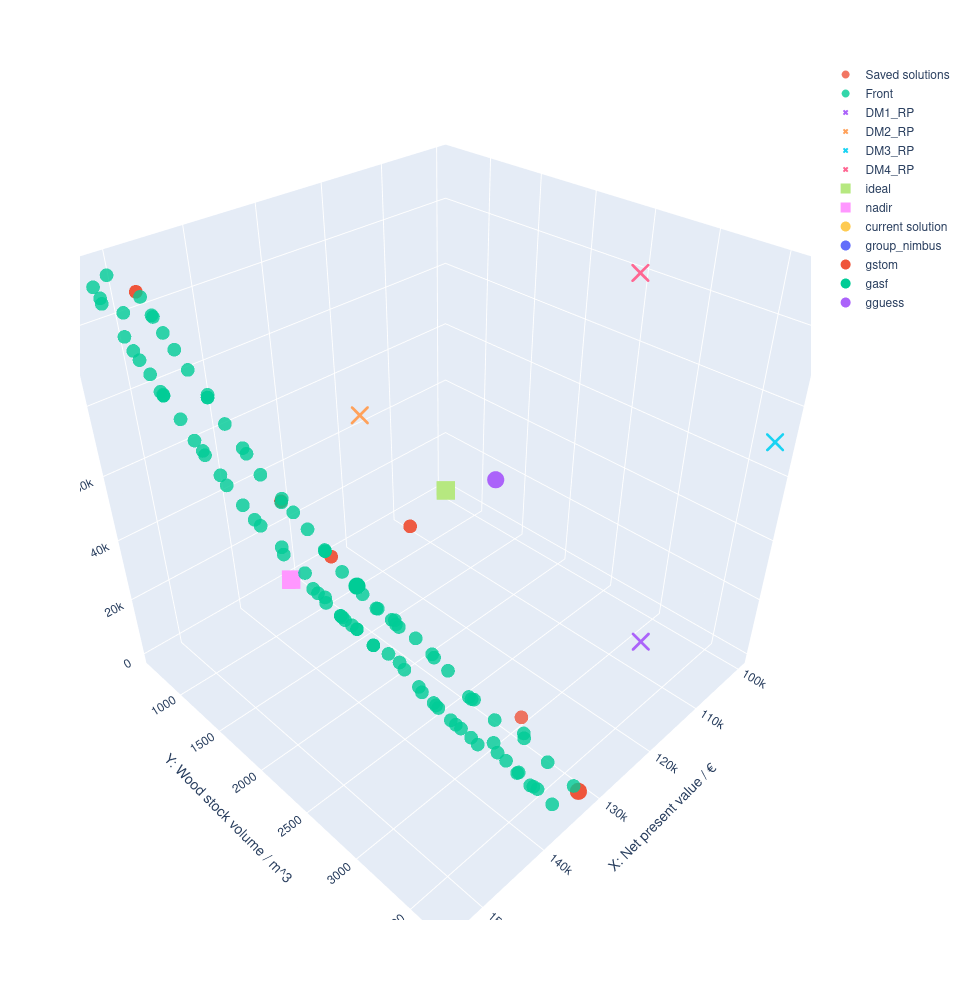

In [46]:
rps = dict_of_rps_to_list_of_rps(reference_points)
rp_arr = np.array([[col["f_1"], col["f_2"],col["f_3"]] for col in rps])

plot_solutions = [next_current_solution, gnimbus, gstom, gasf, gguess]
keys = ["f_1", "f_2", "f_3"]
namelist = ["current solution", "group_nimbus", "gstom", "gasf", "gguess"]

#visu_3d(plot_solutions, rp_arr, keys, namelist, ideals, nadirs, saved_solutions, None)
# See PF
visu_3d(plot_solutions, rp_arr, keys, namelist, ideals, nadirs, saved_solutions, evaluated_points)

### 3. select the next current iteration point by voting procedure

In [43]:
votes_idx = {
    "DM1": 1,
    "DM2": 0,
    "DM3": 1,
    "DM4": 3,
}
## 0 gnimbus puprle
# gstom = solutions[1].optimal_objectives 1 stom yellow
#gasf = solutions[2].optimal_objectives 2 gasf blue
#gguess = solutions[3].optimal_objectives 3 gguess red
res = voting_procedure(forest_problem, solutions, votes_idx)
next_current_solution = res.optimal_objectives
print("next current solution:", next_current_solution)

Plurality winner 1
next current solution: {'f_1': 132036.37628334865, 'f_2': 3703.6032761236183, 'f_3': 3.63657694356011e-05}


### 2. Save found solutions

In [44]:
for i in range(len(plot_solutions)):
    saved_solutions.append(plot_solutions[i])

### Go back to step 1 or move to decision phase

In [47]:
print("next current solution:", next_current_solution)

next current solution: {'f_1': 132036.37628334865, 'f_2': 3703.6032761236183, 'f_3': 3.63657694356011e-05}


# "Decision phase"

In [48]:
reference_points = {
    "DM1": { # Bhupinder
        "f_1": 133000, 
        "f_2": 3200,
        "f_3": 50000,
    },
    "DM2": { # Curro
        "f_1": 130000,
        "f_2": 2000,
        "f_3": 70000,
    },
    "DM3": { # Babooshka
        "f_1": 100000,
        "f_2": 3000,
        "f_3": 70000,
    },
    "DM4": { # Rudolf
        "f_1": 100000,
        "f_2": 1500,
        "f_3": 100000,
    },
}

### let us only propose one solution found by group nimbus which respects each DMs bounds.

In [49]:
num_desired = 1 
solutions = solve_sub_problems(
    forest_problem, next_current_solution, reference_points, num_desired, True,
)
gnimbus_solution = solutions[0].optimal_objectives
print("Final solution candidate:", gnimbus_solution)

RPS {'f_1': 133000, 'f_2': 3200, 'f_3': 50000}
RPS {'f_1': 130000, 'f_2': 2000, 'f_3': 70000}
RPS {'f_1': 100000, 'f_2': 3000, 'f_3': 70000}
RPS {'f_1': 100000, 'f_2': 1500, 'f_3': 100000}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 34 rows, 291 columns and 1771 nonzeros
Model fingerprint: 0x45fe678e
Variable types: 5 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+04]
  Objective range  [1e-11, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+05]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint x_con_1 by 1.000000000

Presolve removed 12 rows and 119 columns
Presolve time: 0.00s
Presolved: 22 rows, 172 columns, 994 nonzeros
Variable types: 5 continuous, 167 integer (167

In [111]:
next_current_solution

{'f_1': 149978.39547189817,
 'f_2': 2282.5711853041485,
 'f_3': 60147.58910573886}

# Ask if the DMs agree upon the final solution. Otherwise go to group discussion.

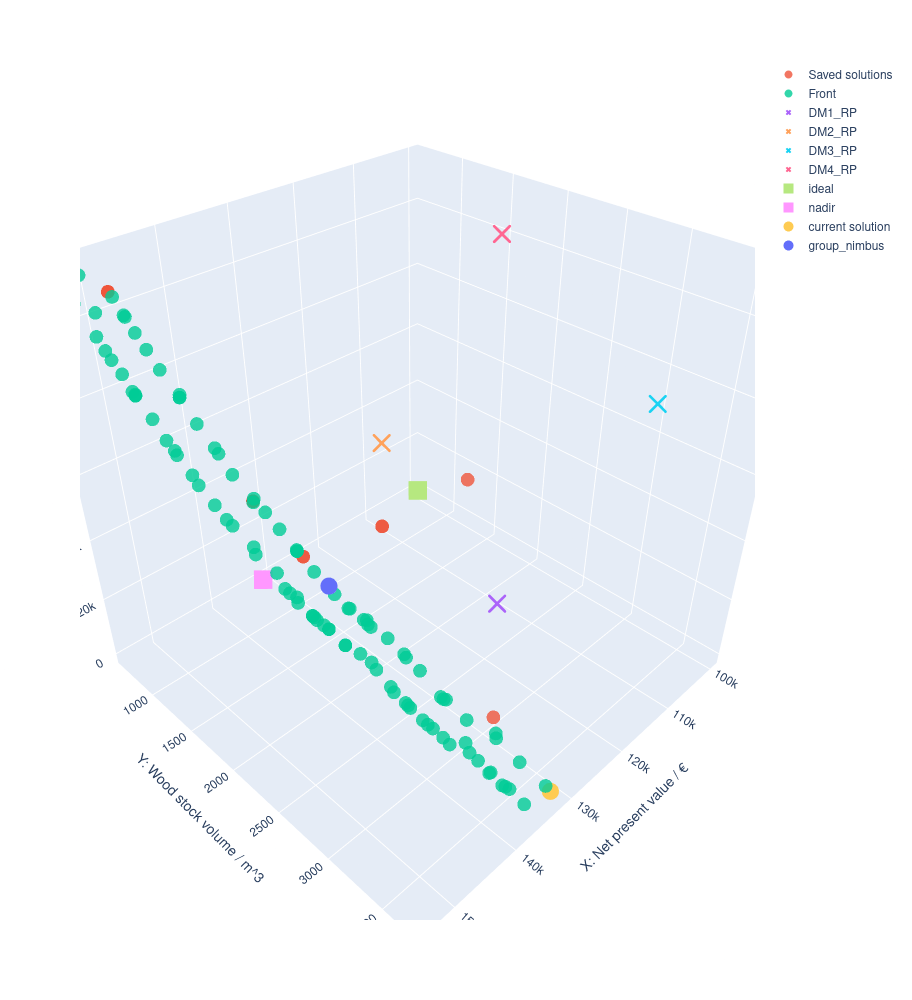

In [50]:
rps = dict_of_rps_to_list_of_rps(reference_points)
rp_arr = np.array([[col["f_1"], col["f_2"],col["f_3"]] for col in rps])

plot_solutions = [next_current_solution, gnimbus]
keys = ["f_1", "f_2", "f_3"]
namelist = ["current solution", "group_nimbus"]

#visu_3d(plot_solutions, rp_arr, keys, namelist, ideals, nadirs, saved_solutions, None)
# See PF
visu_3d(plot_solutions, rp_arr, keys, namelist, ideals, nadirs, saved_solutions, evaluated_points)

# Group discussion:
- give DMs information about the state; what is achievable and what is not, unless preferences are changed. explain why not moving etc.
- Nudge or ask DMs to adjust their preferences to find better suiting solutions for the group.
- Finally, set next_current_solution to gnimbus_solution and go back to DMs giving preferences for the next iteration

In [52]:
next_current_solution = gnimbus_solution

NameError: name 'gnimbus_solution' is not defined